<a href="https://colab.research.google.com/github/ankit-quant/stop-trading/blob/main/930_Straddle_Max_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Aim
- Does Twice the Max Historical DD makes a good parameter to decide when to stop trading?
- Will be using a popular Intraday Option Selling Strategy in Indian Markets for analysis. 

### Rules of Strategy
- Sell an ATM Straddle on BankNifty Options at 9.30 AM
- Place 30% SL on each leg of the Straddle
- Exit at 15.15 or 3.15 PM (close to EOD)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import random
from scipy import stats
import datetime
import calendar
import math
import six
import datetime as dt
import seaborn as sns

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Read the Backtest Report Data from Drive. This data carries a Date Column and a Return Column. 

In [3]:
base_capital=225000

In [4]:
raw=pd.read_csv('/content/drive/MyDrive/Decibel Capital - Public Access/930 Straddle - PNL.csv')

In [5]:
raw['Date']=pd.to_datetime(raw['Date'].apply(lambda x:x[:-5]))
raw['ret']=100*raw['Profit']/base_capital
raw.drop(['Profit'],inplace=True,axis=1)

In [6]:
raw.head()

,Date,ret
0,2017-01-02,-0.176444
1,2017-01-03,0.604444
2,2017-01-04,0.210222
3,2017-01-05,0.199111
4,2017-01-06,-0.114667


In [7]:
# Make a copy of raw data and process it for further use. Here we convert the date column to pandas DateTime and Returns to % returns labels
df_ret=raw.copy()
df_ret.columns = map(str.lower, df_ret.columns)
df_ret['date']=pd.to_datetime(df_ret['date'])
df_ret['ret']=df_ret['ret']
df_ret.head()

,date,ret
0,2017-01-02,-0.176444
1,2017-01-03,0.604444
2,2017-01-04,0.210222
3,2017-01-05,0.199111
4,2017-01-06,-0.114667


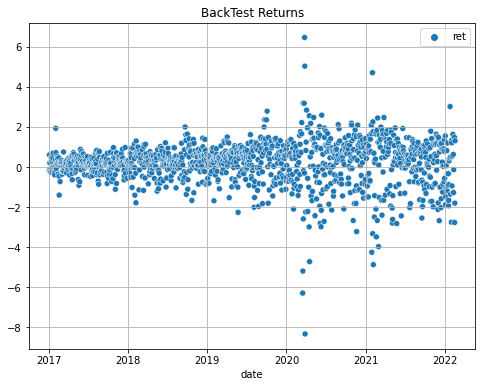

In [8]:
## Plot a Scatter Plot daily returns of the strategy to get an idea of distribution of returns. 
fig,ax=plt.subplots(1,1,figsize=(8,6),sharey=True)
sns.scatterplot(ax=ax,data=df_ret.set_index('date'))
ax.set_title('BackTest Returns')
ax.grid(True,axis='both')

It can be seen from above that this strategy has an expanding volatility of its returns. That is the variation in its returns in 2017 vs that in 2021 are different and increaring in time. This has nothing to do for our analysis, but is for visual purposes.

In [9]:
# Create a Function to Calculate Maximum Drawdown for a given data series
def calc_max_dd(data_series):
  '''
  Inputs:
  data_series (pd.Series): A series of percentage returns of the strategy
  Returns:
  Maximum Drawdown (float)
  '''
  cumm_ret=data_series.cumsum()
  hwm=cumm_ret.cummax()
  dd=cumm_ret-hwm
  return round(min(dd),2)

In [10]:
## Calculate Maximum Drawdown of Strategy in the Backtest
max_dd = calc_max_dd(df_ret['ret'])
print(f'The Maximum Drawdown of this Strategy Backtest is: {max_dd} and Total No. of Trades are: {len(df_ret)}')

The Maximum Drawdown of this Strategy Backtest is: -12.75 and Total No. of Trades are: 1260


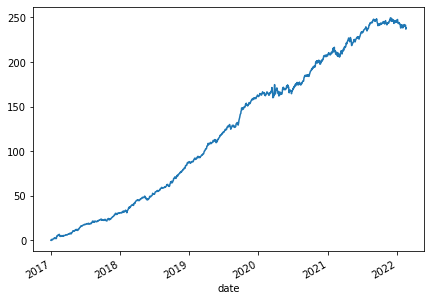

In [11]:
# Visualize the Equity Curve of Our Backtest
df_ret.set_index(df_ret['date'])['ret'].cumsum().plot(figsize=(7,5))

## MONTE CARLO Simulation
For those looking to understand what a Monte Carlo Simulation is, I suggest reading the following introductory artcile: 
https://www.investopedia.com/terms/m/montecarlosimulation.asp

We are going to run a simulation to see our strategy performance under various paths. 

In [12]:
## Define a function to conduct Monte Carlo Simulations
def monte_carlo(simulations,df):
  '''
  Args
  simulations(int) : No. of Simulations to Run for Monte Carlo
  df (DataFrame): DataFrame of Returns with 'ret' as column name for returns
  '''
  mdd_list=[]
  for s in range(simulations):
    mdd=0
    reshuffle=df['ret'].sample(frac=1).reset_index(drop=True)
    plt.plot(reshuffle.cumsum())
    mdd=calc_max_dd(reshuffle)
    mdd_list.append(mdd)
  plt.plot(df['ret'].cumsum(),linewidth=3,color='black')
  plt.xlabel('Trade No.')
  plt.ylabel('Cummulative Returns')
  plt.title('Monte Carlo Simulation for {} Simulations'.format(simulations))
  plt.show()
  return mdd_list

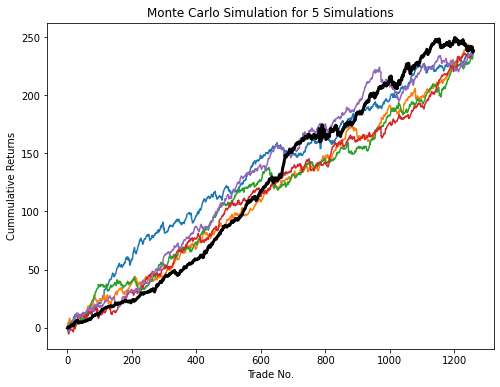

In [13]:
simulations=5
plt.figure(figsize=(8,6))
mdd_list=monte_carlo(simulations,df_ret)

In [14]:
mdd_list

[-12.52, -13.72, -19.53, -10.6, -29.37]

It can be seen in the above case of 5 simulations that with the same starting and ending point of total returns, the reshuffling of order of daily returns will lead to very different Max Drawdowns. It is interesting to note that its the same strategy with same rules, just the returns are shuffled around. 

### Run 10,000 simulations of Monte Carlo 

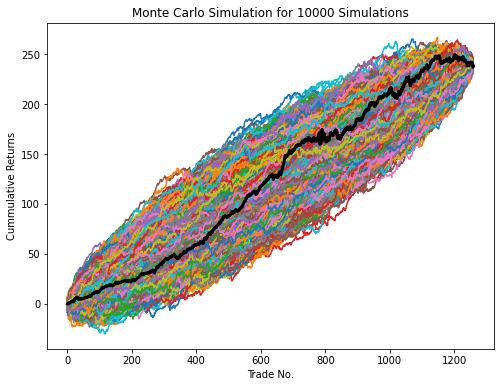

In [15]:
simulations=10000
plt.figure(figsize=(8,6))
mdd_list=monte_carlo(simulations,df_ret)

In [16]:
df_mdd=pd.DataFrame(mdd_list,columns=['Max DD'])

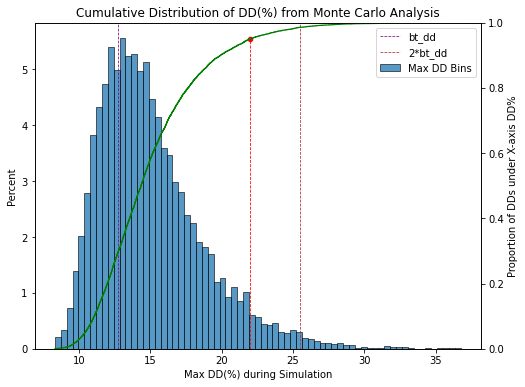

Backtest Drawdown: -12.75% , The 95.0 percentile of the Drawdown based on Monte Carlo is:21.99%


In [17]:
n_tile=0.95 # Cut-Off Percentile to plot 
n_tile_value=np.round(df_mdd['Max DD'].quantile(q=1-n_tile),2)
bt_dd=calc_max_dd(df_ret['ret'])
fig,ax=plt.subplots(1,1,figsize=(8,6))
sns.histplot(ax=ax,x=-1*df_mdd['Max DD'],stat='percent')#,cumulative=True)
ax.set_title('Cumulative Distribution of DD(%) from Monte Carlo Analysis')
ax.set_xlabel('Max DD(%) during Simulation')
ax.axvline(-bt_dd,ymax=1,color='purple',linestyle='dashed',linewidth=0.75)
ax.axvline(-2*bt_dd,ymax=1,color='brown',linestyle='dashed',linewidth=0.75)
ax.legend(labels=['bt_dd','2*bt_dd','Max DD Bins'])
ax2 = ax.twinx()
sns.ecdfplot(ax=ax2,x=-1*df_mdd['Max DD'],color='green',linewidth=1.25)
sns.scatterplot(x=[-1*n_tile_value],y=[n_tile],ax=ax2,color='red')
ax2.axvline(-1*n_tile_value,ymax=n_tile,color='red',linestyle='dashed',linewidth=0.8)
ax2.set_ylabel('Proportion of DDs under X-axis DD%')
plt.show()
print(f'Backtest Drawdown: {bt_dd}% , The {n_tile*100} percentile of the Drawdown based on Monte Carlo is:{-1*n_tile_value}%')

## Analysis
In the above analysis it can be seen that the Strategy has Historical Drawdown of 12.75% in the backtest and a Monte Carlo simulation shows 21.99% DD for a 95%ile cut-off. 
This is better than the popular measure of Twice the DD (25.5%). 

## Alternate Strategy
Here is a similar chart from another Strategy that we run. In this strategy, the Backtest Historical Drawdown is 6.18%, taking the twice the historical DD level to 12.4%. However, the 95%ile on Monte Carlo arrives at close to 15% and thus a naive Twice of Historical DD is not a good measure of potential degradation of strategy. 

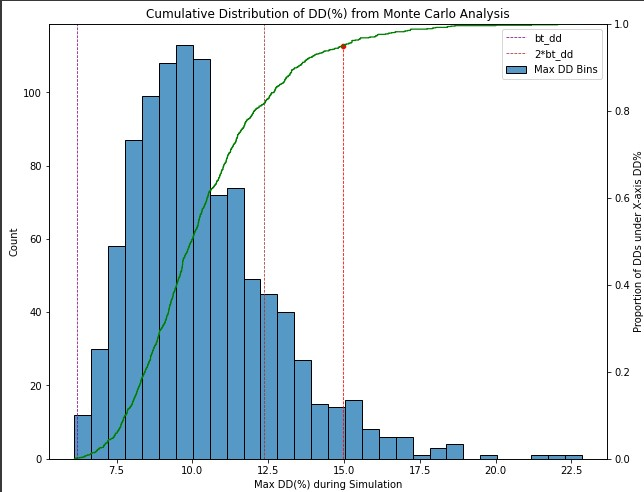